# Data-Set Overview Plots

In [38]:
using QAOA, Distributions, Interpolations
using DataFrames, Arrow, HDF5, Printf
using PyPlot
PyPlot.plt.style.use("./paper.mplstyle")

using PyCall
np = pyimport("numpy")

PATH = "/home/ubuntu/Archives/"
PLOT_PATH = "/home/ubuntu/Archives/plots/SK_model/paper/";

In [39]:
using Revise, SpinFluctuations

In [40]:
Base.show(io::IO, f::Float64) = @printf(io, "%1.4f", f)
Base.show(io::IO, ::MIME"text/latex", df::AbstractDataFrame) = show(df, backend=:html, show_row_number=true, highlighters=:tf_html_default)

normalize!(X) = X ./ maximum(filter(!isnan, X));

## Small-/Large-gap data comparison

In [41]:
N = 9
# N = 11
# N = 13
# N = 15
# N = 17
# N = 19

patterns_dict = Dict(
    9  => r"random_SK_instance_N_9_seed_(\d+)\.h5",
    11 => r"random_SK_instance_N_11_seed_(\d+)\.h5",
    13 => r"random_SK_instance_N_13_seed_(\d+)\.h5",
    15 => r"random_SK_instance_N_15_seed_(\d+)\.h5",
    17 => r"random_SK_instance_N_17_seed_(\d+)\.h5",
    19 => r"random_SK_instance_N_19_seed_(\d+)\.h5"
);

### Loading

In [42]:
npts = 2048
# npts = 2^13
coarse_times = range(0, 1, npts + 1)
exact_times = range(0, 1, 33);

In [43]:
subdir = "small_gaps"
# subdir = "large_gaps"
folder_name = PATH * @sprintf("data/SK_model/N_%i/%s/", N, subdir)
instance_names = readdir(folder_name)
filter!(x -> !occursin("results", x), instance_names)
filter!(x -> !occursin("undecided", x), instance_names)
filter!(x -> !occursin("frustrated", x), instance_names)
filter!(x -> !occursin("main_df", x), instance_names);
folder_name

"/home/ubuntu/Archives/data/SK_model/N_9/small_gaps/"

In [44]:
most_frustrated_spins_seeds = h5read(folder_name * @sprintf("most_undecided_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/seeds", 32768., log10(1e-6)))
most_frustrated_spins_idxs = h5read(folder_name * @sprintf("most_undecided_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/spin_idxs", 32768., log10(1e-6)));
most_frustrated_spins = Dict(zip(most_frustrated_spins_seeds, eachrow(most_frustrated_spins_idxs)))
main_df = DataFrame(Arrow.Table(folder_name * "main_df_undecided.arrow"));

In [45]:
# most_frustrated_spins_seeds = h5read(folder_name * @sprintf("most_frustrated_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/seeds", 32768., log10(1e-6)))
# most_frustrated_spins_idxs = h5read(folder_name * @sprintf("most_frustrated_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/spin_idxs", 32768., log10(1e-6)));
# most_frustrated_spins = Dict(zip(most_frustrated_spins_seeds, eachrow(most_frustrated_spins_idxs)))
# main_df = DataFrame(Arrow.Table(folder_name * "main_df_frustrated.arrow"));

In [46]:
println(size(main_df))
names(main_df)

(2171, 11)


11-element Vector{String}:
 "seed"
 "minigap_locs"
 "eigvals"
 "eigstates"
 "scaled_most_frustrated_flucs"
 "overlaps"
 "gaps"
 "gs_fidelities"
 "mean_scaled_flucs"
 "mean_fields"
 "magnetizations"

## Plots

### Shifted to center

In [47]:
padded_exact_times = range(0, 1, 2(size(exact_times)[1] - 1) + 1)
padded_coarse_times = range(0, 1, 2(size(coarse_times)[1] - 1) + 1);

#### Average plots

In [48]:
function get_mean_shifted_fracs(main_df)
    mean_shifted_fracs = []
    # for row in eachrow(first(main_df, num_instances))
    for row in eachrow(main_df)
        # total_fracs = sum(all_adiabatic_fracs[seed])
        # total_fracs = row[:adiabatic_fracs][1]
        total_fracs = row[:overlaps][1] .* row[:gaps][1].^2

        # get maximum from adiabatic fraction alongside index and time
        max_frac = maximum(total_fracs)
        max_frac_idx = findfirst(x -> x == max_frac, total_fracs)
        max_frac_time = exact_times[max_frac_idx]
        push!(mean_shifted_fracs, shift_idx_to_center(max_frac_idx, total_fracs))
    end

    mean(mean_shifted_fracs)
end

get_mean_shifted_fracs (generic function with 1 method)

In [181]:
function get_mean_shifted_crit_flucs(main_df, most_frustrated_spins)
    
    mean_shifted_crit_flucs = []
    num_instances = 100 # 200 # 500 
    # for row in eachrow(first(main_df, num_instances))
    for row in eachrow(main_df)
        N_val = length(most_frustrated_spins[row[:seed]])
        # print(row[:seed], "\t")
        
        # get maximum from adiabatic fraction alongside index and time
        # total_fracs = sum(row[:adiabatic_fracs])
        total_fracs = row[:overlaps][1] .* row[:gaps][1].^2
        max_frac = maximum(total_fracs)
        max_frac_idx = findfirst(x -> x == max_frac, total_fracs)
        max_frac_time = exact_times[max_frac_idx]

        # find that also for coarse_times
        max_frac_idx_coarse = findfirst(x -> x == max_frac_time, coarse_times)

        frustrated_flucs_1 = row[:scaled_most_frustrated_flucs][1]
        frustrated_flucs_2 = row[:scaled_most_frustrated_flucs][2]

        top_idx = most_frustrated_spins[row[:seed]][1]
        sec_idx = most_frustrated_spins[row[:seed]][2]
        magnetizations = reshape(row[:magnetizations], (N_val, npts+1))

        # inner_navg = 32
        # outer_navg = 32
        # inv_mag_1 = smoothen(smoothen(magnetizations[top_idx, :], coarse_times, navg=inner_navg) .|> abs, coarse_times, navg=outer_navg)
        # inv_mag_2 = smoothen(smoothen(magnetizations[sec_idx, :], coarse_times, navg=inner_navg) .|> abs, coarse_times, navg=outer_navg)
        # inv_mag_1 = smoothen(smoothen(magnetizations[top_idx, :] .|> abs, coarse_times, navg=inner_navg), coarse_times, navg=outer_navg)
        # inv_mag_2 = smoothen(smoothen(magnetizations[sec_idx, :] .|> abs, coarse_times, navg=inner_navg), coarse_times, navg=outer_navg)        
        # inv_mag_1 = smoothen(smoothen(magnetizations[top_idx, :], coarse_times, navg=inner_navg).^2, coarse_times, navg=outer_navg)
        # inv_mag_2 = smoothen(smoothen(magnetizations[sec_idx, :], coarse_times, navg=inner_navg).^2, coarse_times, navg=outer_navg)
        # inv_mag_1 = smoothen(smoothen(magnetizations[top_idx, :].^2, coarse_times, navg=inner_navg), coarse_times, navg=outer_navg)
        # inv_mag_2 = smoothen(smoothen(magnetizations[sec_idx, :].^2, coarse_times, navg=inner_navg), coarse_times, navg=outer_navg)        
        inv_mag_1 = 1
        inv_mag_2 = 1
        # crit_flucs = [shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_1, coarse_times) ./ inv_mag_1), 
        #               shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_2, coarse_times) ./ inv_mag_2)]   
                      
        mean_fields = reshape(row[:mean_fields][3], (N_val, npts+1))
        # EA_param_1 = sum([mean_fields[k, :].^2 for k in 1:N_val]) ./ N_val
        # EA_param_2 = sum([mean_fields[k, :].^2 for k in 1:N_val]) ./ N_val
        # EA_param_1 = smoothen(mean_fields[top_idx, :].^2, coarse_times)
        # EA_param_2 = smoothen(mean_fields[sec_idx, :].^2, coarse_times)        
        # crit_flucs = [shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_1, coarse_times) .* EA_param_1 ./ inv_mag_1), 
        #               shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_2, coarse_times) .* EA_param_2 ./ inv_mag_2)]
        EA_param_1 = mean_fields[top_idx, :].^2
        EA_param_2 = mean_fields[sec_idx, :].^2
        crit_navg = 64
        crit_flucs = [shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_1 .* EA_param_1, coarse_times, navg=crit_navg)), 
                      shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_2 .* EA_param_2, coarse_times, navg=crit_navg))] 
        # crit_flucs = [shift_idx_to_center(max_frac_idx_coarse, smoothen(EA_param_1, coarse_times, navg=crit_navg)), 
                    #   shift_idx_to_center(max_frac_idx_coarse, smoothen(EA_param_2, coarse_times, navg=crit_navg))]            

        # EA_param_1 = 1 ./ mean_fields[top_idx, :].^2
        # EA_param_2 = 1 ./ mean_fields[sec_idx, :].^2  
        # EA_param_1 = sum([smoothen(1 ./ mean_fields[i, :].^2, coarse_times, navg=128) for i in 1:N-1])
        # EA_param_2 = sum([smoothen(1 ./ mean_fields[i, :].^2, coarse_times, navg=128) for i in 1:N-1])
        # EA_param_1 = 1 ./ smoothen(mean_fields[top_idx, :].^2, coarse_times, navg=256)
        # EA_param_2 = 1 ./ smoothen(mean_fields[sec_idx, :].^2, coarse_times, navg=256)              
        # EA_param_1 = 1.
        # EA_param_2 = 1.

        # inner_navg = 32
        # outer_navg = 32
        # crit_flucs = [shift_idx_to_center(max_frac_idx_coarse, smoothen(smoothen(frustrated_flucs_1 .* EA_param_1, coarse_times, navg=inner_navg), coarse_times, navg=outer_navg)), 
        #               shift_idx_to_center(max_frac_idx_coarse, smoothen(smoothen(frustrated_flucs_2 .* EA_param_2, coarse_times, navg=inner_navg), coarse_times, navg=outer_navg))]                

        crit_idx = reverse!(sort([(1, normalize!(crit_flucs[1])[npts+1]), (2, normalize!(crit_flucs[2])[npts+1])], by=x->x[2]))[1][1]

        push!(mean_shifted_crit_flucs,  crit_flucs[crit_idx])
        # push!(mean_shifted_crit_flucs,  mean(crit_flucs))
    end
    mean_shifted_crit_flucs
end

get_mean_shifted_crit_flucs (generic function with 1 method)

In [182]:
N_vals = [9, 11, 13, 15, 17, 19]
all_mean_shifted_fracs = []
all_mean_shifted_crit_flucs = []
for N in N_vals
    try
        folder_name = PATH * @sprintf("data/SK_model/N_%i/%s/", N, subdir)

        most_frustrated_spins_seeds = h5read(folder_name * @sprintf("most_undecided_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/seeds", 32768., log10(1e-6)))
        most_frustrated_spins_idxs = h5read(folder_name * @sprintf("most_undecided_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/spin_idxs", 32768., log10(1e-6)));
        most_frustrated_spins = Dict(zip(most_frustrated_spins_seeds, eachrow(most_frustrated_spins_idxs)))
        main_df = DataFrame(Arrow.Table(folder_name * "main_df_undecided.arrow"))      
        
        # most_frustrated_spins_seeds = h5read(folder_name * @sprintf("most_frustrated_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/seeds", 32768., log10(1e-6)))
        # most_frustrated_spins_idxs = h5read(folder_name * @sprintf("most_frustrated_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/spin_idxs", 32768., log10(1e-6)));
        # most_frustrated_spins = Dict(zip(most_frustrated_spins_seeds, eachrow(most_frustrated_spins_idxs)))
        # main_df = DataFrame(Arrow.Table(folder_name * "main_df_frustrated.arrow"))

        mean_shifted_fracs = get_mean_shifted_fracs(main_df)
        mean_shifted_crit_flucs = get_mean_shifted_crit_flucs(main_df, most_frustrated_spins)
        push!(all_mean_shifted_fracs, mean_shifted_fracs)    
        push!(all_mean_shifted_crit_flucs, mean_shifted_crit_flucs)   
    catch err
        println(N, ", ", err, ", ") 
    end
end

2171
2169
1939
1050
250
110


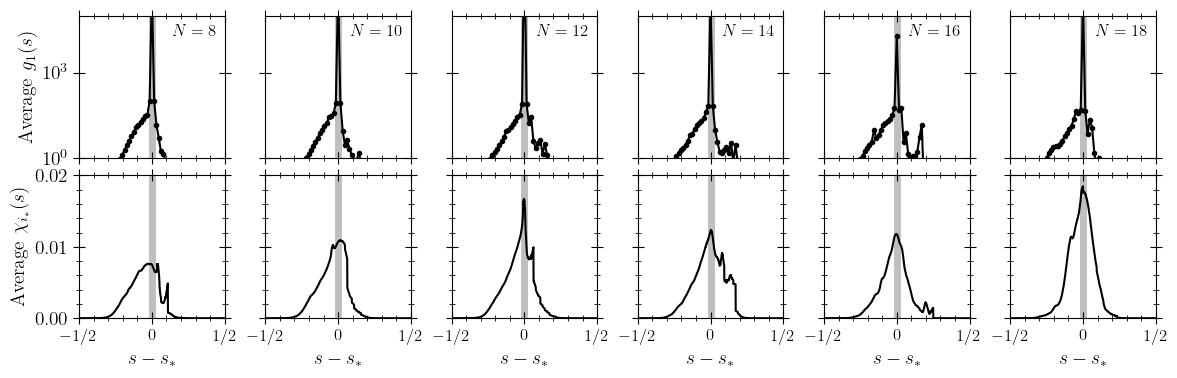

In [184]:
figure(figsize=(12, 4))
for (k, mean_shifted_fracs) in enumerate(all_mean_shifted_fracs)
    ax = subplot(2, 6, k)
    axvline(0, c="k", alpha=0.25, lw=5)
    semilogy(padded_exact_times .- 1/2, mean_shifted_fracs, "-ok", lw=1.5, ms=3)#, label=@sprintf("\$N = %i\$", N_vals[k] - 1))
    semilogy([], [], "-k", lw=0 , label=@sprintf("\$N = %i\$", N_vals[k] - 1))
    xlim(-0.5, 0.5)
    ax.set_xticklabels([-0.25, 0.0, 0.25])
    ylim(1e0, 1e5)
    ax.set_xticklabels([])
    if k == 1
        ylabel("Average \$ g_1(s)  \$")
    else
        ax.set_yticklabels([])
    end   
    # legend(frameon=false, handlelength=0, markerscale=0, borderaxespad=0.1, fontsize=12, loc="upper right")
    legend(frameon=false, borderaxespad=0.1, fontsize=12, loc="upper right")
end

all_y_data = mean.(all_mean_shifted_crit_flucs)
for (k, y_data) in enumerate(all_y_data)
    println(length(all_mean_shifted_crit_flucs[k]))
    ax = subplot(2, 6, k + 6)
    axvline(0, c="k", alpha=0.25, lw=5)
    # plot(padded_coarse_times .- 1/2, normalize!(y_data), "-k")
    plot(padded_coarse_times .- 1/2, y_data, "-k")
    xlabel("\$s - s_*\$")
    xlim(-0.5, 0.5)
    # ax.set_xticklabels(["\$-\\frac 12\$", "\$0\$", "\$\\frac 12\$"], fontsize=12)
    ax.set_xticklabels(["\$-1/2\$", "\$0\$", "\$1/2\$"], fontsize=12)
    ylim(0, )
    ylim(0, 0.02)
    if k == 1
        ylabel("Average \$ \\chi_{i_*}(s) \$")
    else
        ax.set_yticklabels([])
    end    
end
tight_layout(h_pad=0.0, w_pad=0.5)
# savefig(PLOT_PATH * "disorder_stats.pdf", dpi=256, bbox_inches="tight")

In [180]:
for row in eachrow(first(main_df, 2))
    size(row[:gs_fidelities]) |> println
end

(33,)
(33,)


#### Single-instance plots

In [ ]:
num_instances = 10

for (k, row) in enumerate(eachrow(main_df))
    # for (k, row) in enumerate(eachrow(last(main_df, num_instances)))
    print(k, "\t") # row[:seed]
    total_fracs = row[:overlaps][1] .* row[:gaps][1].^2

    # get maximum from adiabatic fraction alongside index and time
    max_frac = maximum(total_fracs)
    max_frac_idx = findfirst(x -> x == max_frac, total_fracs)
    max_frac_time = exact_times[max_frac_idx]

    # find that also for coarse_times
    max_frac_idx_coarse = findfirst(x -> x == max_frac_time, coarse_times)

    frustrated_flucs_1 = row[:scaled_most_frustrated_flucs][1]
    frustrated_flucs_2 = row[:scaled_most_frustrated_flucs][2]

    figure(figsize=(4, 3))
    title(row[:seed])
    ax = subplot(211)
    axvline(0, c="k", alpha=0.25, lw=5)
    plot(padded_exact_times .- 1/2, shift_idx_to_center(max_frac_idx, normalize!(row[:overlaps][1] .* row[:gaps][1].^2)), lw=1.5, "-k")
    plot(padded_exact_times .- 1/2, shift_idx_to_center(max_frac_idx, row[:overlaps][1]), lw=1.5, "-C0")
    plot(padded_exact_times .- 1/2, shift_idx_to_center(max_frac_idx, row[:overlaps][2]), lw=1.5, "-C1")
    plot(padded_exact_times .- 1/2, shift_idx_to_center(max_frac_idx, 1 ./ row[:gaps][1]), lw=0.5, "--C0")
    plot(padded_exact_times .- 1/2, shift_idx_to_center(max_frac_idx, 1 ./ row[:gaps][2]), lw=0.5, "--C1") 

    plot(padded_exact_times .- 1/2, shift_idx_to_center(max_frac_idx, abs.(row[:gs_fidelities]).^2), "-r")

    plot([], [], label=@sprintf("%i", maximum(total_fracs)))   
    xlim(-1/2, 1/2)
    ylim(0, )
    # ylabel("\$\\frac{|\\langle \\alpha|H_Z-H_X|0\\rangle|}{E_\\alpha - E_0}\$")
    ax.set_xticklabels([])
    legend(frameon=false)

    ax = subplot(212)

    top_idx = most_frustrated_spins[row[:seed]][1]
    sec_idx = most_frustrated_spins[row[:seed]][2]
    magnetizations = reshape(row[:magnetizations], (length(most_frustrated_spins[row[:seed]]), npts+1))

    inner_navg = 64
    outer_navg = 64
    inv_mag_1 = smoothen(smoothen(magnetizations[top_idx, :], coarse_times, navg=inner_navg) .|> abs, coarse_times, navg=outer_navg)
    inv_mag_2 = smoothen(smoothen(magnetizations[sec_idx, :], coarse_times, navg=inner_navg) .|> abs, coarse_times, navg=outer_navg)
    # crit_flucs = [shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_1, coarse_times) ./ inv_mag_1), 
                #   shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_2, coarse_times) ./ inv_mag_2)]                  
    crit_flucs = [shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_1, coarse_times)), 
                  shift_idx_to_center(max_frac_idx_coarse, smoothen(frustrated_flucs_2, coarse_times))]
                
    which_spin(X) = abs(0.5 - padded_coarse_times[findfirst(x -> x == maximum(filter(!isnan, X)), X)])
    crit_idx = sort([(1, which_spin(crit_flucs[1])), (2, which_spin(crit_flucs[2]))], by=x->x[2])[1][1]
    crit_idx = reverse!(sort([(1, normalize!(crit_flucs[1])[npts+1]), (2, normalize!(crit_flucs[2])[npts+1])], by=x->x[2]))[1][1]
    # println(maximum(filter(!isnan, crit_flucs[1])), ", ", maximum(filter(!isnan, crit_flucs[2])), ", ", shift_idx_to_center(max_frac_idx, total_fracs) |> maximum)

    spin_max_loc(X) = padded_coarse_times[findfirst(x -> x == maximum(filter(!isnan, X)), X)]
    # axvline.([spin_max_loc(crit_flucs[1]), spin_max_loc(crit_flucs[2])], c="k")
    axvline(0, c="k", alpha=0.25, lw=5)
    # plot(padded_coarse_times .- 1/2, crit_flucs[crit_idx], "-k", label=row[:seed])
    plot(padded_coarse_times .- 1/2, crit_flucs[1] |> normalize!, "-C0", label=row[:seed])
    plot(padded_coarse_times .- 1/2, crit_flucs[2] |> normalize!, "-C1")

    plot(padded_coarse_times .- 1/2, shift_idx_to_center(max_frac_idx_coarse, normalize!(1 ./ inv_mag_1)), "--C0")
    plot(padded_coarse_times .- 1/2, shift_idx_to_center(max_frac_idx_coarse, normalize!(1 ./ inv_mag_2)), "--C1")    

    mean_fields = reshape(row[:mean_fields][3], (N-1, npts+1))
    plot(padded_coarse_times .- 1/2, shift_idx_to_center(max_frac_idx_coarse, sum([mean_fields[k, :].^2 for k in 1:N-1])) ./ (N-1), "-k", alpha=0.5)
    plot(padded_coarse_times .- 1/2, shift_idx_to_center(max_frac_idx_coarse, sum([mean_fields[k, :].^8 for k in 1:N-1])) ./ (N-1), "-k")

    xlim(-1/2, 1/2)
    ylim(0, 1)
    xlabel("\$s - s_*\$")
    legend(frameon=false)

    tight_layout(pad=0.0)
    # savefig(PATH * @sprintf("plots/SK_model/N_%i/%s/", N, "details") * @sprintf("random_SK_instance_N_%i_hardness_%i.pdf", N, k), dpi=128, bbox_inches="tight")
    # close()
end

### Critical points

In [ ]:
function get_max_frac_times(main_df)
    max_frac_times = []
    for row in eachrow(main_df)
        total_fracs = row[:overlaps][1] .* row[:gaps][1].^2

        # get maximum from adiabatic fraction alongside index and time
        max_frac = maximum(total_fracs)
        max_frac_idx = findfirst(x -> x == max_frac, total_fracs)
        max_frac_time = exact_times[max_frac_idx]
        push!(max_frac_times, max_frac_time)
    end

    max_frac_times
end

In [ ]:
N_vals = [9, 11, 13, 15, 17, 19]
all_max_frac_times = []
for N in N_vals
    try
        folder_name = PATH * @sprintf("data/SK_model/N_%i/%s/", N, subdir)

        # most_frustrated_spins_seeds = h5read(folder_name * @sprintf("most_undecided_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/seeds", 32768., log10(1e-6)))
        # most_frustrated_spins_idxs = h5read(folder_name * @sprintf("most_undecided_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/spin_idxs", 32768., log10(1e-6)));
        # most_frustrated_spins = Dict(zip(most_frustrated_spins_seeds, eachrow(most_frustrated_spins_idxs)))
        # main_df = DataFrame(Arrow.Table(folder_name * "main_df_undecided.arrow"))      
        
        most_frustrated_spins_seeds = h5read(folder_name * @sprintf("most_frustrated_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/seeds", 32768., log10(1e-6)))
        most_frustrated_spins_idxs = h5read(folder_name * @sprintf("most_frustrated_spins_N_%i.h5", N), @sprintf("T_final_%.0f_tol_1e%.0f/spin_idxs", 32768., log10(1e-6)));
        most_frustrated_spins = Dict(zip(most_frustrated_spins_seeds, eachrow(most_frustrated_spins_idxs)))
        # main_df = DataFrame(Arrow.Table(folder_name * "main_df_frustrated.arrow"))
        main_df = DataFrame(Arrow.Table(folder_name * "main_df_frustrated_nondeg.arrow"))

        max_frac_times = get_max_frac_times(main_df)
        push!(all_max_frac_times, max_frac_times)
    catch err
        println(N, ", ", err, ", ") 
    end
end

In [ ]:
all_max_frac_times[1]

## Testing

In [ ]:
max_frac_times_1 = []
max_frac_times_2 = []
for N in N_vals
    try
        folder_name = PATH * @sprintf("data/SK_model/N_%i/%s/", N, subdir)

        for row in eachrow(main_df)
            total_fracs = row[:overlaps][1] .* row[:gaps][1]
            
            # get maximum from adiabatic fraction alongside index and time
            max_frac = maximum(total_fracs)
            max_frac_idx = findfirst(x -> x == max_frac, total_fracs)
            max_frac_time = exact_times[max_frac_idx]
            push!(max_frac_times_1, max_frac_time)

            total_fracs = row[:overlaps][1] .* row[:gaps][1].^2

            # get maximum from adiabatic fraction alongside index and time
            max_frac = maximum(total_fracs)
            max_frac_idx = findfirst(x -> x == max_frac, total_fracs)
            max_frac_time = exact_times[max_frac_idx]
            push!(max_frac_times_2, max_frac_time)
        end
    catch err
        println(N, ", ", err, ", ") 
    end
end